In [16]:
from google.colab import output
output.enable_custom_widget_manager()

# Traffic Signal Optimization - Implementation Based on QUBO Formulation

Cities often face traffic congestion during major urban events such as concerts, sports games, festivals, or political gatherings. These events lead to sudden increases in traffic volume, which traditional traffic management systems struggle to handle. Unmanaged congestion can result in longer travel times, increased carbon emissions, public dissatisfaction, and challenges for emergency vehicles trying to navigate crowded streets.


Here, we explain the problem setup, formulation, and implementation of the present program for signal control based on the QUBO formulation in the following order:

- 1\. [Problem setup](#1)
- 2\. [Formulation](#2)
  - 2.1\. [Concept](#2_1)
  - 2.2\. [Objective function](#2_2)
  - 2.3\. [Summary of formulation](#2_3)
- 3\. [Implementation of traffic signal control](#3)
  - 3.1\. [Preparation](#3_1)
  - 3.2\. [Class "`Roads`" for roads](#3_2)
  - 3.3\. [Class "`Signals`" for signals](#3_3)
  - 3.4\. [Class "`Traffic`" for the number of cars](#3_4)
  - 3.5\. [Class "`IsingVariable`" for Ising variables](#3_5)
  - 3.6\. [Initial state](#3_6)
  - 3.7\. [Class "`Simulation`" for simulation](#3_7)
  - 3.8\. [Main function](#3_8)
- 4\. [Summary](#4)

<a id="1"></a>.
## 1\. Problem setup

We make the following assumptions about the city and its traffic in this example program for simplicity.

* The city has a square grid road network

* There are traffic lights at each intersection to control north-south and east-west traffic at different times of the day.

* There is no outflow or inflow of vehicles to the outside of the city.

* At all intersections, the percentage of cars going straight, turning right, or turning left is constant (i.e., no specific origin or destination for each car).

Based on the above simplification, this example program implements optimal control of signals based on the following three policies.

1. Improve the flow of cars  

    In this case, we define the state of "good car flow" as "at each intersection, there is a slight bias between the number of cars coming from the north/south and the number of vehicles coming from the east/west.

2. Keep signal colors the same as long as possible.

    In reality, signals only change sometimes.

3. maximize the number of cars flowing at any one time  

    Our goal is to minimize the number of cars waiting for the signal.

In this example program, using combinatorial optimization, we search for the state of the signal that best satisfies the above policies.

<a id="2"></a>

## 2\. Formulation

Here, we introduce various formulations for optimization and simulation.

<a id="2_1"></a>

### 2.1\. Concept

We use the above policy to formulate optimal traffic light control conditions. First, we define the constants and variables needed for the formulation.

### Constants

* $N$: Number of traffic lights in the north-south and east-west directions

* $a$: Probability of going straight at each intersection

* $\displaystyle\frac{1-a}{2}$: Probability of turning left and right (the same probability is assumed)

### Variables.

* $s_i(t)$: State of the traffic light at intersection $i$ at time $t$.

    * $s_i(t)=1$: Greein in north-south direction (red in east-west direction)

    * $s_i(t)=-1$: Green in the east-west direction (red in the north-south direction)  
     
* $q_i(t)$: Number of vehicles from adjacent intersections to intersection $i$ at time $t$ (normalized to 1 for the maximum number of vehicles that can flow through the intersection at any time)

    * $q_i^n(t)$: Number of cars entering from the north

    * $q_i^s(t)$: Number of cars entering from the south

    * $q_i^e(t)$: Number of cars entering from the east

    * $q_i^w(t)$: Number of cars entering from the west

<div align="center">
<img src="../figures/qubo_traffic/q_i.png" alt="" title="q_i" width="640px">
</div>

<a id="2_2"></a>

### 2.2\. Objective function

Based on the three policies described in "[1\. Problem setting](#1)", we introduce the following concept of time to formulate the objective function.

1. **At the following time $t+1$, there is a minimum bias between the numbers of vehicles entering from the north-south and east-west directions at each intersection**

    Minimize the difference between the number of vehicles coming from the north-south direction and the number of cars coming from the east-west direction.

    $$
    \text{minimize}\quad\sum_{i}^{N^2}\Bigl(\bigl(q_i^n(t+1)+q_i^s(t+1)\bigr)-\bigl(q_i^e(t+1)+q_i^w(t+1)\bigr)\Bigr)^2
    $$

2. **The color of each signal continues to be the same as long as possible**

    Minimize the difference in the states of the traffic light between the current and previous times.

    $$
    \text{minimize}\quad\sum_{i}^{N^2}\left(\frac{s_i(t)-s_i(t-1)}{2}\right)^2
    $$


3. **Maximize the number of cars entering at the next time $t+1$**

    We need to determine which direction, north-south or east-west, should be green to maximize the outflow of the cars.

    $$
    \text{maximize}\quad\sum_{i}^{N^2}\left(\frac{1+s_i(t)}{2}\bigl(q_i^n(t)+q_i^s(t)\bigr)-\frac{1-s_i(t)}{2}\bigl(q_i^e(t)+q_i^w(t)\bigr)\right)
    $$

Adding these functions together yields the final objective function `cost`.

- `car_bias_cost` $\displaystyle= \sum_{i}^{N^2}\Bigl(\bigl(q_i^n(t+1)+q_i^s(t+1)\bigr)-\bigl(q_i^e(t+1)+q_i^w(t+1)\bigr)\Bigr)^2$

- `signal_cost` $\displaystyle= \sum_{i}^{N^2}\left(\frac{s_i(t)-s_i(t-1)}{2}\right)^2$

- `car_flow_cost` $\displaystyle= -\sum_{i}^{N^2}\left(\frac{1+s_i(t)}{2}\bigl(q_i^n(t)+q_i^s(t)\bigr)-\frac{1-s_i(t)}{2}\bigl(q_i^e(t)+q_i^w(t)\bigr)\right)$

- `cost` $\displaystyle= \alpha \times$ `car_bias_cost` $\displaystyle+ \beta \times$ `signal_cost` $\displaystyle+ \gamma \times$ `car_flow_cost`

Here, $\alpha$, $\beta$, and $\gamma$ are the weights of the terms in the respective objective functions, which we can adjust to obtain better results ($\alpha,\beta,\gamma > 0$).

In this example program, the operation of finding the signal state $s(t)$ at the current time $t$ that minimizes the objective function `cost` through combinatorial optimization is repeated each time during the simulation.

<a id="2_3"></a>
### 2.3\. Summary of formulation

The traffic signal optimization problem can be formulated from the above. There are no constraints.

- minimize `cost` $= \alpha\: \times$ `car_bias_cost` $+ \beta\: \times$ `signal_cost` $+ \gamma\: \times$ `car_flow_cost`

- `car_bias_cost` $\displaystyle= \sum_{i}^{N^2}\Bigl(\bigl(q_i^n(t+1)+q_i^s(t+1)\bigr)-\bigl(q_i^e(t+1)+q_i^w(t+1)\bigr)\Bigr)^2$

- `signal_cost` $\displaystyle= \sum_{i}^{N^2}\left(\frac{s_i(t)-s_i(t-1)}{2}\right)^2$

- `car_flow_cost` $\displaystyle= \sum_{i}^{N^2}-\left(\frac{1+s_i(t)}{2}\bigl(q_i^n(t)+q_i^s(t)\bigr)-\frac{1-s_i(t)}{2}\bigl(q_i^e(t)+q_i^w(t)\bigr)\right)$

- $s_i(t) \in \{-1, 1\}$


<a id="3"></a>
## 3\. Implementation of traffic signal control


<a id="3.1"></a>

### 3.1\. Preparation

First, we import the necessary Python libraries and create a client for the Ising machine (Fixstars Amplify) we will use.

In [6]:
!pip install matplotlib amplify ipympl sigfig

In [7]:
%matplotlib widget

from __future__ import annotations

import itertools
import random
import numpy as np
from amplify import VariableGenerator, PolyArray, solve, FixstarsClient
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from sigfig import round
from typing import Union, Tuple


# Create Fixstars Amplify client
client = FixstarsClient()
client.token = "AE/7B3XW5OaiqZVyZTIiLHMnOIHiVyTNLa5"
client.parameters.timeout = 1000  # Timeout 1 second

<a id="3_2"></a>
### 3.2\. Class "`Roads`" for roads

The `Roads` class manages variables that store information about the city's road network.

### Variables
* $\text{num_road}$：Number of the intersections along one edge of the city
* $\text{can_come_from_\{north, south, east, west\}}$：Whether cars can enter the intersection from that direction
* $\text{can_go_to_\{north, south, east, west\}}$：Whether cars can leave from the intersection towards that direction

In [8]:
class Roads:
    def __init__(
        self,
        num_road: int,
        init_can_come_from: list[np.ndarray],
        straight_rate: float = 0.6,
    ):
        # Whether cars can enter the intersection from each direction
        self._can_come_from_north = init_can_come_from[0]
        self._can_come_from_south = init_can_come_from[1]
        self._can_come_from_east = init_can_come_from[2]
        self._can_come_from_west = init_can_come_from[3]

        # Check various conditions
        assert num_road == len(self._can_come_from_north) - 2
        assert self._can_come_from_north.shape == self._can_come_from_south.shape
        assert self._can_come_from_north.shape == self._can_come_from_east.shape
        assert self._can_come_from_north.shape == self._can_come_from_west.shape
        assert self._can_come_from_north.shape[0] == self._can_come_from_north.shape[1]
        assert 0 <= straight_rate <= 1

        # Number of intersections on one side of the
        self._num_road = num_road

        # Percentage of cars going straight at intersections
        self._straight_rate = straight_rate

        # Which direction can cars procesed from the intersection = np.roll of from which direction cars enter the intersection
        self._can_go_to_north = np.roll(self._can_come_from_south, 1, axis=0)
        self._can_go_to_south = np.roll(self._can_come_from_north, -1, axis=0)
        self._can_go_to_east = np.roll(self._can_come_from_west, -1, axis=1)
        self._can_go_to_west = np.roll(self._can_come_from_east, 1, axis=1)

    @property
    def num_road(self):
        return self._num_road

    @property
    def straight_rate(self):
        return self._straight_rate

    @property
    def can_come_from_north(self):
        return self._can_come_from_north

    @property
    def can_come_from_south(self):
        return self._can_come_from_south

    @property
    def can_come_from_east(self):
        return self._can_come_from_east

    @property
    def can_come_from_west(self):
        return self._can_come_from_west

    @property
    def can_go_to_north(self):
        return self._can_go_to_north

    @property
    def can_go_to_south(self):
        return self._can_go_to_south

    @property
    def can_go_to_east(self):
        return self._can_go_to_east

    @property
    def can_go_to_west(self):
        return self._can_go_to_west

<a id="3_3"></a>
### 3.3\. Class "`Signals`" for signals

The `Signals` class manages the following variables that store the state of the signals.

- Signal state.
  - `init_signal`, `pre_signal`, `current_signal`:  
    Whether the signal is green in the north-south or east-west direction

  - `signal_weight`:  
    Weight of the term about the traffic light in the cost function

In [9]:
class Signals:
    def __init__(self, roads: Roads, signal_weight: float, seed: int = 0):
        self._roads = roads

        # Weight for the cost function related to signals
        self._signal_weight = signal_weight

        # Initial state of the signals
        init_signal = np.zeros((self._roads.num_road + 2, self._roads.num_road + 2))

        # Initializing the signals
        random.seed(seed)
        for i, j in itertools.product(
            range(1, self._roads.num_road + 1), range(1, self._roads.num_road + 1)
        ):
            if (random.randint(0, 1)) == 0:
                init_signal[i, j] = -1
            else:
                init_signal[i, j] = 1

        # State of previous traffic lights by one time step
        self._pre_signal = np.copy(init_signal)

        # Current state of traffic lights at t
        self._current_signal = init_signal

    @property
    def signal_weight(self):
        return self._signal_weight

    @property
    def pre_signal(self):
        return self._pre_signal

    @pre_signal.setter
    def pre_signal(self, value):
        self._pre_signal = value

    @property
    def current_signal(self):
        return self._current_signal

    @current_signal.setter
    def current_signal(self, value):
        self._current_signal = value

<a id="3_4"></a>
### 3.4\. Class "`Traffic`" for the number of cars

The `Traffic` class manages the process related to the number of cars.

In `next_step_num_car`, we first perform the `[2\. Preparation](#2)" and calculates the inflow and outflow of cars. The number of vehicles at the next time is calculated based on them. In this function, there are two patterns: one is the case where the state of the traffic light contains an Ising variable, and the other is the case where the state of the traffic light is a NumPy array.  

Also, in `car_bias_model` and `car_flow`, we calculate for the cost functions `car_bias_cost` and `car_flow_cost`.

<!-- ### 変数
* $\text{num\_car\_from\_\{north, south, east, west\}}$：Number of  cars heading to this intersection from that direction
* $\text{car\_flow\_weight}$: Weight on the cost function related to the number of car flow
* $\text{car\_bias\_weight}$: Weight on the cost function related to the bias
-->

In [10]:
class Traffic:
    def __init__(
        self,
        roads: Roads,
        init_cars: list[np.ndarray],
        car_bias_weight: float,
        car_flow_weight: float,
    ):
        self._roads = roads

        # Number of cars heading to the intersection from each direction
        self._num_car_from_north = init_cars[0]
        self._num_car_from_south = init_cars[1]
        self._num_car_from_east = init_cars[2]
        self._num_car_from_west = init_cars[3]

        # Weight for the cost function related to the car flow
        self._car_flow_weight = car_flow_weight

        # Weight for the cost function related to the car bias
        self._car_bias_weight = car_bias_weight

    @property
    def num_car_from_north(self):
        return self._num_car_from_north

    @num_car_from_north.setter
    def num_car_from_north(self, value):
        self._num_car_from_north = value

    @property
    def num_car_from_south(self):
        return self._num_car_from_south

    @num_car_from_south.setter
    def num_car_from_south(self, value):
        self._num_car_from_south = value

    @property
    def num_car_from_east(self):
        return self._num_car_from_east

    @num_car_from_east.setter
    def num_car_from_east(self, value):
        self._num_car_from_east = value

    @property
    def num_car_from_west(self):
        return self._num_car_from_west

    @num_car_from_west.setter
    def num_car_from_west(self, value):
        self._num_car_from_west = value

    @property
    def car_flow_weight(self):
        return self._car_flow_weight

    @property
    def car_bias_weight(self):
        return self._car_bias_weight

    # Calculating the number of cars at next time step
    def _next_step_num_car(self, signal: Union[np.ndarray, PolyArray]) -> Union[
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
        Tuple[PolyArray, PolyArray, PolyArray, PolyArray],
    ]:
        # Definition of variables to store the number of cases at next time step
        if isinstance(signal, PolyArray):
            temp_num_car_from_north = PolyArray(self._num_car_from_north)
            temp_num_car_from_south = PolyArray(self._num_car_from_south)
            temp_num_car_from_east = PolyArray(self._num_car_from_east)
            temp_num_car_from_west = PolyArray(self._num_car_from_west)
        else:
            temp_num_car_from_north = self._num_car_from_north.copy()
            temp_num_car_from_south = self._num_car_from_south.copy()
            temp_num_car_from_east = self._num_car_from_east.copy()
            temp_num_car_from_west = self._num_car_from_west.copy()

        # At each intersection
        for i, j in itertools.product(
            range(1, self._roads.num_road + 1), range(1, self._roads.num_road + 1)
        ):
            # Array for the number of cases entering from each direction
            from_car_array = np.zeros(4)
            from_car_array[0] = min(self._num_car_from_north[i, j], 1)
            from_car_array[1] = min(self._num_car_from_south[i, j], 1)
            from_car_array[2] = min(self._num_car_from_east[i, j], 1)
            from_car_array[3] = min(self._num_car_from_west[i, j], 1)

            # If the signal is green for north-south direction
            NS_flow_flag = (-signal[i, j] * (signal[i, j] - 1)) / 2 + 1

            # If the signal is green for west-east direction
            EW_flow_flag = (-signal[i, j] * (signal[i, j] + 1)) / 2 + 1

            # The matrix A_s_j to compute the number of cars outgoing from the intersection based on the number of cars heading to the intersection
            if isinstance(signal, PolyArray):
                from_to_array = PolyArray(np.zeros((4, 4)))
            else:
                from_to_array = np.zeros((4, 4))

            # A factor to compute the number of cars heading towards north
            fromS_toN = NS_flow_flag * (
                (signal[i, j] ** 2) * (self._roads.straight_rate - 1) + 1
            )
            fromE_toN = EW_flow_flag * (
                (1 - self._roads.can_go_to_south[i, j] / 2)
                * (1 - (self._roads.straight_rate * self._roads.can_go_to_west[i, j]))
            )
            fromW_toN = EW_flow_flag * (
                (1 - self._roads.can_go_to_south[i, j] / 2)
                * (1 - (self._roads.straight_rate * self._roads.can_go_to_east[i, j]))
            )

            # A factor to compute the number of cars heading towards south
            fromN_toS = NS_flow_flag * (
                (signal[i, j] ** 2) * (self._roads.straight_rate - 1) + 1
            )
            fromE_toS = EW_flow_flag * (
                (1 - self._roads.can_go_to_north[i, j] / 2)
                * (1 - (self._roads.straight_rate * self._roads.can_go_to_west[i, j]))
            )
            fromW_toS = EW_flow_flag * (
                (1 - self._roads.can_go_to_north[i, j] / 2)
                * (1 - (self._roads.straight_rate * self._roads.can_go_to_east[i, j]))
            )

            # A factor to compute the number of cars heading towards east
            fromN_toE = NS_flow_flag * (
                (1 - self._roads.can_go_to_west[i, j] / 2)
                * (1 - (self._roads.straight_rate * self._roads.can_go_to_south[i, j]))
            )
            fromS_toE = NS_flow_flag * (
                (1 - self._roads.can_go_to_west[i, j] / 2)
                * (1 - (self._roads.straight_rate * self._roads.can_go_to_north[i, j]))
            )
            fromW_toE = EW_flow_flag * (
                (signal[i, j] ** 2) * (self._roads.straight_rate - 1) + 1
            )

            # A factor to compute the number of cars heading towards west
            fromN_toW = NS_flow_flag * (
                (1 - self._roads.can_go_to_east[i, j] / 2)
                * (1 - (self._roads.straight_rate * self._roads.can_go_to_south[i, j]))
            )
            fromS_toW = NS_flow_flag * (
                (1 - self._roads.can_go_to_east[i, j] / 2)
                * (1 - (self._roads.straight_rate * self._roads.can_go_to_north[i, j]))
            )
            fromE_toW = EW_flow_flag * (
                (signal[i, j] ** 2) * (self._roads.straight_rate - 1) + 1
            )

            # The array A_s_j to compute the number of cars outgoing from the intersection based on the number of cars heading to the intersection
            # We multiply can_go_to_{north, south, east, west} as there might not be a road towards that direction from the intersection
            from_to_array[0, 1] = fromS_toN * self._roads.can_go_to_north[i, j]
            from_to_array[0, 2] = fromE_toN * self._roads.can_go_to_north[i, j]
            from_to_array[0, 3] = fromW_toN * self._roads.can_go_to_north[i, j]

            from_to_array[1, 0] = fromN_toS * self._roads.can_go_to_south[i, j]
            from_to_array[1, 2] = fromE_toS * self._roads.can_go_to_south[i, j]
            from_to_array[1, 3] = fromW_toS * self._roads.can_go_to_south[i, j]

            from_to_array[2, 0] = fromN_toE * self._roads.can_go_to_east[i, j]
            from_to_array[2, 1] = fromS_toE * self._roads.can_go_to_east[i, j]
            from_to_array[2, 3] = fromW_toE * self._roads.can_go_to_east[i, j]

            from_to_array[3, 0] = fromN_toW * self._roads.can_go_to_west[i, j]
            from_to_array[3, 1] = fromS_toW * self._roads.can_go_to_west[i, j]
            from_to_array[3, 2] = fromE_toW * self._roads.can_go_to_west[i, j]

            # The number of cars outgoing from the intersection
            to_car_array = (from_to_array * from_car_array).sum(axis=1)

            # Update "temp_num_car", which is inflow of cars
            temp_num_car_from_north[i + 1, j] += to_car_array[1]
            temp_num_car_from_south[i - 1, j] += to_car_array[0]
            temp_num_car_from_east[i, j - 1] += to_car_array[3]
            temp_num_car_from_west[i, j + 1] += to_car_array[2]

            # Update "temp_num_car", which is outflow of cars
            # The outflow amount changes depending on the state of signal
            temp_num_car_from_north[i, j] -= NS_flow_flag * from_car_array[0]
            temp_num_car_from_south[i, j] -= NS_flow_flag * from_car_array[1]
            temp_num_car_from_east[i, j] -= EW_flow_flag * from_car_array[2]
            temp_num_car_from_west[i, j] -= EW_flow_flag * from_car_array[3]

        return (
            temp_num_car_from_north,
            temp_num_car_from_south,
            temp_num_car_from_east,
            temp_num_car_from_west,
        )

    # Update the number of cars based on the results
    def update_num_car(self, signal: np.ndarray):
        (
            self._num_car_from_north,
            self._num_car_from_south,
            self._num_car_from_east,
            self._num_car_from_west,
        ) = self._next_step_num_car(signal)

    # Compute the difference between the number of cars from east/west and from north/south
    def current_car_bias(self) -> np.ndarray:
        car_bias = (
            (self._num_car_from_north + self._num_car_from_south)
            - (self._num_car_from_east + self._num_car_from_west)
        ) / 2

        return car_bias

    #  Compute the difference between the number of cars from east/west and from north/south at the next time step for the calculation of "car_bias_cost"
    def car_bias_model(self, signal: PolyArray) -> PolyArray:
        # Compute the number of cars in the next time step
        (
            temp_num_car_from_north,
            temp_num_car_from_south,
            temp_num_car_from_east,
            temp_num_car_from_west,
        ) = self._next_step_num_car(signal)

        # Compute the difference between the number of cars from east/west and from north/south based on the number of cars at the next time step
        next_car_bias = (
            (temp_num_car_from_north + temp_num_car_from_south)
            - (temp_num_car_from_east + temp_num_car_from_west)
        ) / 2

        return next_car_bias

    # Compute the flow of the cars for "car_flow_cost"
    def car_flow(self, signal: PolyArray) -> PolyArray:
        # Initialize "car_flow"
        car_flow = 0

        # At each intersection
        for i, j in itertools.product(
            range(1, self._roads.num_road + 1), range(1, self._roads.num_road + 1)
        ):
            # If there is a signal
            if signal[i, j] != 0:
                # If green in north/south direction
                num_car_north_and_south = min(self._num_car_from_north[i, j], 1) + min(
                    self._num_car_from_south[i, j], 1
                )
                # If green in east/west direction
                num_car_east_and_west = min(self._num_car_from_east[i, j], 1) + min(
                    self._num_car_from_west[i, j], 1
                )

                # The state of signal determines whether cars move in north/south direction or east/west direction
                car_flow += (signal[i, j] + 1) / 2 * num_car_north_and_south - (
                    signal[i, j] - 1
                ) / 2 * num_car_east_and_west

            # If there is no signal
            # Or an intersection where cars cannot turn
            else:
                car_flow += (
                    min(self._num_car_from_north[i, j], 1)
                    * self._roads.can_come_from_north[i, j]
                    + min(self._num_car_from_south[i, j], 1)
                    * self._roads.can_come_from_south[i, j]
                    + min(self._num_car_from_east[i, j], 1)
                    * self._roads.can_come_from_east[i, j]
                    + min(self._num_car_from_west[i, j], 1)
                    * self._roads.can_come_from_west[i, j]
                )

        return car_flow

<a id="3_5"></a>
### 3.5\. Class `IsingVariable` for Ising variables

The `IsingVariable` class manages the decision variables `variables` for the state of the traffic light at the next time $t+1$.

In [11]:
class IsingVariable:
    def __init__(self, roads: Roads):
        # Generate Ising decision variable
        gen = VariableGenerator()
        self._variables = gen.array(
            "Ising", shape=(roads.num_road + 2, roads.num_road + 2)
        )

        self._variables[0, :] = 0
        self._variables[roads.num_road + 1, :] = 0
        self._variables[:, 0] = 0
        self._variables[:, roads.num_road + 1] = 0

        # At each intersection
        # In case of no signal
        for i, j in itertools.product(
            range(1, roads.num_road + 1), range(1, roads.num_road + 1)
        ):
            # At a corner
            if (
                (roads.can_come_from_north[i, j] == 1)
                ^ (roads.can_come_from_south[i, j] == 1)
            ) and (
                (roads.can_come_from_east[i, j] == 1)
                ^ (roads.can_come_from_west[i, j] == 1)
            ):
                self._variables[i, j] = 0

            # For a straight road
            if (
                abs(
                    (roads.can_come_from_north[i, j] + roads.can_come_from_south[i, j])
                    - (roads.can_come_from_east[i, j] + roads.can_come_from_west[i, j])
                )
                == 2
            ):
                self._variables[i, j] = 0

            # Or no road ahead
            if (
                roads.can_come_from_north[i, j]
                + roads.can_come_from_south[i, j]
                + roads.can_come_from_east[i, j]
                + roads.can_come_from_west[i, j]
                == 0
            ):
                self._variables[i, j] = 0

    @property
    def variables(self):
        return self._variables

<a id="3_6"></a>
### 3.6\. Initial state

We create the `City` class to determine the initial state of a city based on the following two items.

* The direction cars can enter each intersection from.

* The number of cars heading to each intersection

In [12]:
import numpy as np
import itertools
import random


class City:
    def __init__(self, num_road: int):
        self.num_road = num_road
        self.can_come_from_north = np.zeros((num_road + 2, num_road + 2))
        self.can_come_from_south = np.zeros((num_road + 2, num_road + 2))
        self.can_come_from_east = np.zeros((num_road + 2, num_road + 2))
        self.can_come_from_west = np.zeros((num_road + 2, num_road + 2))

        self.num_car_from_north = np.zeros((num_road + 2, num_road + 2))
        self.num_car_from_south = np.zeros((num_road + 2, num_road + 2))
        self.num_car_from_east = np.zeros((num_road + 2, num_road + 2))
        self.num_car_from_west = np.zeros((num_road + 2, num_road + 2))

    # Randomly determine the initial number of cars
    def set_num_cars(self, variance: float, average: float):
        random.seed(314)
        self.num_car_from_north = (
            np.random.lognormal(
                average, variance, (self.num_road + 2, self.num_road + 2)
            )
            * self.can_come_from_north
        )
        self.num_car_from_south = (
            np.random.lognormal(
                average, variance, (self.num_road + 2, self.num_road + 2)
            )
            * self.can_come_from_south
        )
        self.num_car_from_east = (
            np.random.lognormal(
                average, variance, (self.num_road + 2, self.num_road + 2)
            )
            * self.can_come_from_east
        )
        self.num_car_from_west = (
            np.random.lognormal(
                average, variance, (self.num_road + 2, self.num_road + 2)
            )
            * self.can_come_from_west
        )


def Grid(num_road: int, variance: float, average: float):
    grid = City(num_road)

    # Flag to determine whether cars can enter the intersection from each direction
    # This program assumes grid network
    for i, j in itertools.product(range(1, num_road + 1), range(1, num_road + 1)):
        if i == 1:
            grid.can_come_from_north[i, j] = 0
        else:
            grid.can_come_from_north[i, j] = 1
        if i == num_road:
            grid.can_come_from_south[i, j] = 0
        else:
            grid.can_come_from_south[i, j] = 1
        if j == num_road:
            grid.can_come_from_east[i, j] = 0
        else:
            grid.can_come_from_east[i, j] = 1
        if j == 1:
            grid.can_come_from_west[i, j] = 0
        else:
            grid.can_come_from_west[i, j] = 1

    # Set the number of cars based on given variance and average
    grid.set_num_cars(variance, average)

    return grid

<a id="3_7"></a>
### 3.7\. Class `Simulation` for simulation

In the `Simulation` class, `step()` performs optimal control of traffic signals for one time step and updates the number of cars. Also, `plot_traffic()` plots the road network, traffic signals, and number of vehicles. This class also generates images to visualize the results.

In [13]:
import matplotlib.figure


class Simulation:
    def __init__(
        self,
        city: City,
        straight_rate: float,
        car_bias_weight: float,
        car_flow_weight: float,
        signal_weight: float,
        fig,
        ax,
    ):
        # Initialize all classes based on given conditions
        init_can_come_from = [
            city.can_come_from_north,
            city.can_come_from_south,
            city.can_come_from_east,
            city.can_come_from_west,
        ]
        init_cars = [
            city.num_car_from_north,
            city.num_car_from_south,
            city.num_car_from_east,
            city.num_car_from_west,
        ]
        num_road = city.num_road

        self._roads = Roads(num_road, init_can_come_from, straight_rate)
        self._signals = Signals(self._roads, signal_weight)
        self._cars = Traffic(self._roads, init_cars, car_bias_weight, car_flow_weight)
        self._ising = IsingVariable(self._roads)

        self.num_step = 0

        self.fig = fig
        self.ax = ax

    # Plot roads and the number of cars
    def plot_traffic(self) -> plt.figure:
        self.fig.set_size_inches(self._roads.num_road, self._roads.num_road)

        self.ax.clear()

        self.ax.set_xlim(0, self._roads.num_road + 1)
        self.ax.set_ylim(0, self._roads.num_road + 1)

        for i, j in itertools.product(
            range(1, self._roads.num_road + 1), range(1, self._roads.num_road + 1)
        ):
            x = j
            y = self._roads.num_road + 1 - i

            # Roads
            if self._roads.can_come_from_north[i, j] == 1:
                self.ax.vlines(x, y, y + 1, color="black", zorder=1)  # north
            if self._roads.can_come_from_south[i, j] == 1:
                self.ax.vlines(x, y - 1, y, color="black", zorder=1)  # south
            if self._roads.can_come_from_east[i, j] == 1:
                self.ax.hlines(y, x, x + 1, color="black", zorder=1)  # east
            if self._roads.can_come_from_west[i, j] == 1:
                self.ax.hlines(y, x - 1, x, color="black", zorder=1)  # west

            current_car_bias = self.get_car_bias()

            # Traffic lights
            if self._signals.current_signal[i, j] != 0:
                if (
                    self._signals.current_signal[i, j] == 1
                ):  # Plotted in blue for north/south direction
                    self.ax.plot(
                        x,
                        y,
                        marker="$⇅$",
                        color="blue",
                        markersize=abs(current_car_bias[i, j]) * 20,
                        zorder=2,
                    )

                else:  # Plotted in red for east/west direction
                    self.ax.plot(
                        x,
                        y,
                        marker="$⇆$",
                        color="red",
                        markersize=abs(current_car_bias[i, j]) * 20,
                        zorder=2,
                    )

            fontsize = 8

            # The number of cars heading each direction
            if self._roads.can_come_from_north[i, j] == 1:
                self.ax.text(
                    x + 0.1,
                    y + 0.5,
                    "↓" + str(round(self._cars.num_car_from_north[i, j], sigfigs=1)),
                    ha="left",
                    va="center",
                    size=fontsize,
                )

            if self._roads.can_come_from_south[i, j] == 1:
                self.ax.text(
                    x - 0.1,
                    y - 0.5,
                    str(round(self._cars.num_car_from_south[i, j], sigfigs=1)) + "↑",
                    ha="right",
                    va="center",
                    size=fontsize,
                )

            if self._roads.can_come_from_east[i, j] == 1:
                self.ax.text(
                    x + 0.5,
                    y - 0.1,
                    "← " + str(round(self._cars.num_car_from_east[i, j], sigfigs=1)),
                    ha="center",
                    va="top",
                    size=fontsize,
                )

            if self._roads.can_come_from_west[i, j] == 1:
                self.ax.text(
                    x - 0.5,
                    y + 0.1,
                    str(round(self._cars.num_car_from_west[i, j], sigfigs=1)) + " →",
                    ha="center",
                    va="bottom",
                    size=fontsize,
                )

        self.ax.set_title(f"t = {self.num_step}")

        [
            self.ax.spines[side].set_visible(False)
            for side in ["right", "left", "top", "bottom"]
        ]
        self.ax.tick_params(
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False,
            bottom=False,
            left=False,
            right=False,
            top=False,
        )

        return None

    # Computing cost
    # bias of the number of cars in north/south and east/west
    def calc_car_bias_cost(self) -> PolyArray:
        # Compute the difference between the number of cars in east/west and that in north/south
        next_car_bias = self._cars.car_bias_model(self._ising.variables)
        # Obtain the cost by accumulate squared "next_car_bias"
        car_bias_cost = (next_car_bias * next_car_bias).sum()

        return car_bias_cost

    # State of traffic lights
    def calc_signal_cost(self) -> PolyArray:
        # Compute the difference of states between previous and current time steps
        signal_cost = (
            ((self._ising.variables - self._signals.pre_signal) / 2) ** 2
        ).sum()

        return signal_cost

    # Flow of cars
    def calc_car_flow_cost(self) -> PolyArray:
        # Compute the car flow and its negative value if the cost
        car_flow_cost = -self._cars.car_flow(self._ising.variables)

        return car_flow_cost

    # Add up all the cost functions constructed
    def calc_cost(self) -> PolyArray:
        car_bias_cost = self.calc_car_bias_cost()
        signal_cost = self.calc_signal_cost()
        car_flow_cost = self.calc_car_flow_cost()

        # Multiply weights for each cost function
        cost = (
            self._cars.car_bias_weight * car_bias_cost
            + self._signals.signal_weight * signal_cost
            + self._cars.car_flow_weight * car_flow_cost
        )

        return cost

    # Perform traffic simulation for one time step while performing signal control
    def step(self):
        # Compute the cost
        model = self.calc_cost()

        # Obtain the optimal signal state by solving QUBO
        result = solve(model, client)
        if len(result) == 0:
            raise RuntimeError("Any one of constraints is not satisfied.")

        values = result[0].values

        # Update the state of the signals based on the QUBO results
        self._signals.current_signal = self._ising.variables.decode(values)

        # Update the number of cars based on the obtained signal state
        self._cars.update_num_car(self._signals.current_signal)

        # Store the state of the current signals
        self._signals.pre_signal = np.copy(self._signals.current_signal)

        self.num_step += 1

    def get_car_bias(self):
        return self._cars.current_car_bias()

<a id="3_8"></a>
### 3.8\. Main function

The `main` function performs the following process.

* Determine initial values for each parameter of the city

* Setting the weights of the cost function

* Run the traffic simulation with optimal signal control for the desired number of time steps

In the result animation, the size of each arrow corresponds to the number of cars going in that direction.

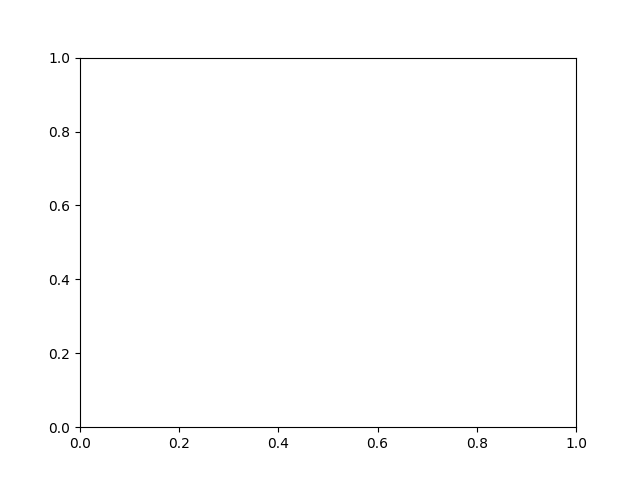

<ipython-input-13-b2f16a5acd7e>:207: DeprecationWarning: PolyArray.decode is deprecated since amplify v1.0.0 and will no longer support in the near future.
Use PolyArray.evaluate instead. Please see the migration guide for details: https://amplify.fixstars.com/docs/amplify/v1/migration.html
  self._signals.current_signal = self._ising.variables.decode(values)
<ipython-input-13-b2f16a5acd7e>:207: DeprecationWarning: PolyArray.decode is deprecated since amplify v1.0.0 and will no longer support in the near future.
Use PolyArray.evaluate instead. Please see the migration guide for details: https://amplify.fixstars.com/docs/amplify/v1/migration.html
  self._signals.current_signal = self._ising.variables.decode(values)
<ipython-input-13-b2f16a5acd7e>:207: DeprecationWarning: PolyArray.decode is deprecated since amplify v1.0.0 and will no longer support in the near future.
Use PolyArray.evaluate instead. Please see the migration guide for details: https://amplify.fixstars.com/docs/amplify/v1

In [17]:
# The number of steps to be simulated
num_step = 50

# The number of roads, initial variance and average
num_road = 10
init_variance = 0.5  # 0-1
init_average = 0

# Initialize the city
city = Grid(num_road, init_variance, init_average)

# Percentage of cars heading straight at intersections
straight_rate = 0.6

# Weights of each cost functions (determine them so that orders of the costs are more or less the same)
car_bias_weight = 2.0
car_flow_weight = 1.0
signal_weight = 1.0

fig, ax = plt.subplots()

sim = Simulation(
    city,
    straight_rate,
    car_bias_weight,
    car_flow_weight,
    signal_weight,
    fig,
    ax,
)


# Function to execute the simulation and optimization
def update(i: int):
    sim.plot_traffic()
    sim.step()


# Display simulation results in animation
anim = FuncAnimation(fig, update, frames=num_step, repeat=False)

<a id="4"></a>
## 4\. Summary

In this example program, we introduced real-time traffic light control based on combinatorial optimization for simplified urban traffic and performed traffic simulations for such control. The simplification assumes a constant ratio of cars going straight and turning left and right at all intersections. However, based on historical traffic data, the ratio can be set for each intersection and at each time of day to perform more realistic traffic light control.

Also, in the present case, we performed real-time traffic light control in response to ever-changing traffic conditions.